Welcome to your assignment this week! 

To better understand explainable AI, in this assignment, we will look at the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way. We use a real-world dataset on Census income, also known as the __[*Adult dataset*](https://archive.ics.uci.edu/ml/datasets/Adult)__ available in the *UCI* ML Repository where we will predict if the potential income of people is more than $50K/year or not.

For this assignment, we will use: 

- [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
- [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) which is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements. Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.




__[LIME GitHub](https://github.com/marcotcr/lime)__


**After this assignment you will be able to:** use the __LIME__ framework to explain potential black-box machine learning models in a model-agnostic way.




Run the following cell to load the packages you will need.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap
import itertools

##
from utils import *
##

from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import graphviz
from io import StringIO
from sklearn import datasets,tree
import pydot
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image


import warnings
warnings.filterwarnings('ignore')
#plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

Next, let's load the census dataset. Run the following cell to load the features `X` and the labels `y`. 

In [41]:
X_raw, y = shap.datasets.adult(display=True)

X_raw = X_raw.drop(columns=['Capital Gain']) # These two features are intentionally removed.
X_raw = X_raw.drop(columns=['Capital Loss']) # These two features are intentionally removed.

labels = np.array([int(label) for label in y])

print('The shape of X_raw is: ',X_raw.shape)
print('The shape of y is: ',labels.shape)

The shape of X_raw is:  (32561, 10)
The shape of y is:  (32561,)


You've loaded:

- `X_raw`: a DataFrame containing 32,561 instances with 12 features.
- `y`: the list of binary labels for the 32,561 examples. If salary of instance $i$ is more than \\$50K: $y^{(i)} = 1$ otherwise: $y^{(i)} = 0$.


# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


|Num| Attribute Name | Type | Description |
|----|----------------------------------------------------------|------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|1| Age | Continuous | Represents age of the person <br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked)|
|2| Workclass | Categorical | Represents the workclass of the person. <br> (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,<br> Local-gov, State-gov, Without-pay, Never-worked). |
|3| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
|4| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
|5| Occupation | Categorical | Represents the type of profession job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
|6| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
|7| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
|8| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
|9| Capital Gain | Continuous | The total capital gain for the person |
|10| Capital Loss | Continuous | The total capital loss for the person |
|11| Hours per week | Continuous | Total hours spent working per week |
|12| Country | Categorical | The country where the person was born |
|13| Income Label  | Categorical | The class label column is the one we want to predict |     



We have a total of 12 features and our objective is to predict if the income of a person will be more than $\$50$K  (True) or less than $\$50$K (False). Hence we will be building and interpreting a classification model. 

Let's have a look at the first three instances of the dataset (you can use `X.head(3)` to see the content of the dataset):


![](images/dataset.png)


For example, the first person is 39 years old, works for the state governement, is a Male and was born in the US. By using `y[0:3]` you can get  binary values indicating whether these persons have an income higher than $\$50$K or no.

# Pre-processing
Converting the categorical columns with string values to numeric representations. Typically the XGBoost model can handle categorical data natively being a tree-based model so we don't one-hot encode the features

In [42]:
mapping = {}
cat_cols = X_raw.select_dtypes(['category']).columns
for col in cat_cols:
    mapping[col] = dict( enumerate(X_raw[col].cat.categories ) )
indices_cat_cols = [ list(X_raw.columns).index(x) for x in cat_cols ]
X = X_raw.copy()
X[cat_cols] = X_raw[cat_cols].apply(lambda x: x.cat.codes)
headers=list(X.columns)
X.head(3)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country
0,39.0,7,13.0,4,1,1,4,1,40.0,39
1,50.0,6,13.0,2,4,0,4,1,13.0,39
2,38.0,4,9.0,0,6,1,4,1,40.0,39


Let's have a look at the distribution of people with <=  $\$50$K (0) and > $\$50$K (1) income:

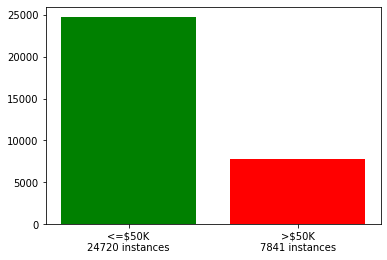

In [43]:
plt.bar([0], height=[Counter(labels)[0]], color="green")
plt.bar([1], height=[Counter(labels)[1]], color="red")
plt.xticks([0, 1], ['<=$50K\n'+str(Counter(labels)[0])+' instances',
                    '>$50K\n'+str(Counter(labels)[1])+' instances'])
plt.show()

# Split Train and Test Datasets

As in any Machine Learning, we need to partition the dataset into two subsets -- a training and testset. Please note that in practice, the dataset needs to be partitioned into three subsets, the third once being the validation set which will be used for hyperparameters tuning. However, in this assignment, we will not tune the hyperparameters.

Run the following to split the dataset accordingly:


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42, stratify=y)
print('The shape of training set is: ',X_train.shape)
print('The shape of test set is: ',X_test.shape)


The shape of training set is:  (22792, 10)
The shape of test set is:  (9769, 10)


You've created:

- `X_train`: a trainig DataFrame containing 22,792 instances used for training.
- `y_train`: the list of binary labels for the 22,792 instances of the training set.
- `X_test`: a test DataFrame containing 9,769 instances used for  testing.
- `y_test`: the list of binary labels for the 9,769 instances of the test set.

We note that since we are using a stratified splitting, the distribution of samples in the training and test set is similar to the distribution in the dataset, i.e., roughly 24% of positive examples in each subset.

## Training the classification model

Now we train and build a boosting classification model on our training data using [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

Run the following to start the training of the classifier:

In [45]:
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

# Predictions on the test data

Now that the classifier is trained, let's make few predictions on the test set:

In [46]:
predictions = xgc.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


As you can see, our classier is making only 2 errors!

# Model Performance 
 Let's now evaluate the performance of our classifier on the test set. For that, we will call `sklearn.metrics.classification_report()` which returns a text report showing the main classification metrics including: Presicion, Recall, and F1-Score. The reported averages include macro average (averaging the unweighted mean per label) and weighted average (averaging the support-weighted mean per label). 




 

In [47]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      7417
           1       0.67      0.60      0.64      2352

    accuracy                           0.83      9769
   macro avg       0.78      0.76      0.76      9769
weighted avg       0.83      0.83      0.83      9769



To get more details, let's print the confusion matrix:

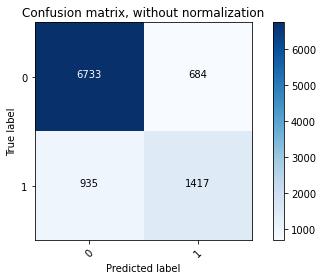

In [48]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')

***

**Task 1**: Please provide comments on the performance of the classifier.

***

On the test set, the XGBoost classifier performs well. There are just few inaccuracies in the first comparison of the true and predicted values for the first twenty test samples, demonstrating good accuracy. In addition to macro and weighted averages, the classification report offers detailed metrics for each classes, including precision, recall, and F1-score. These measures suggest that the model can effectively differentiate between people who make above $50,000 and those who make less than $50,000. The confusion matrix also demonstrates that there are very few incorrect classifications and that many predictions are accurate. For this binary classification problem, the classifier is generally reliable and efficient.

# Feature importance:

The global feature importance calcuations that come with XGBoost, enables us to view feature importances based on the following:

- **Feature Weights**: This is based on the number of times a feature appears in a tree across the ensemble of trees.
- **Gain**: This is based on the average gain of splits which use the feature.
- **Coverage**: This is based on the average coverage (number of samples affected) of splits which use the feature.

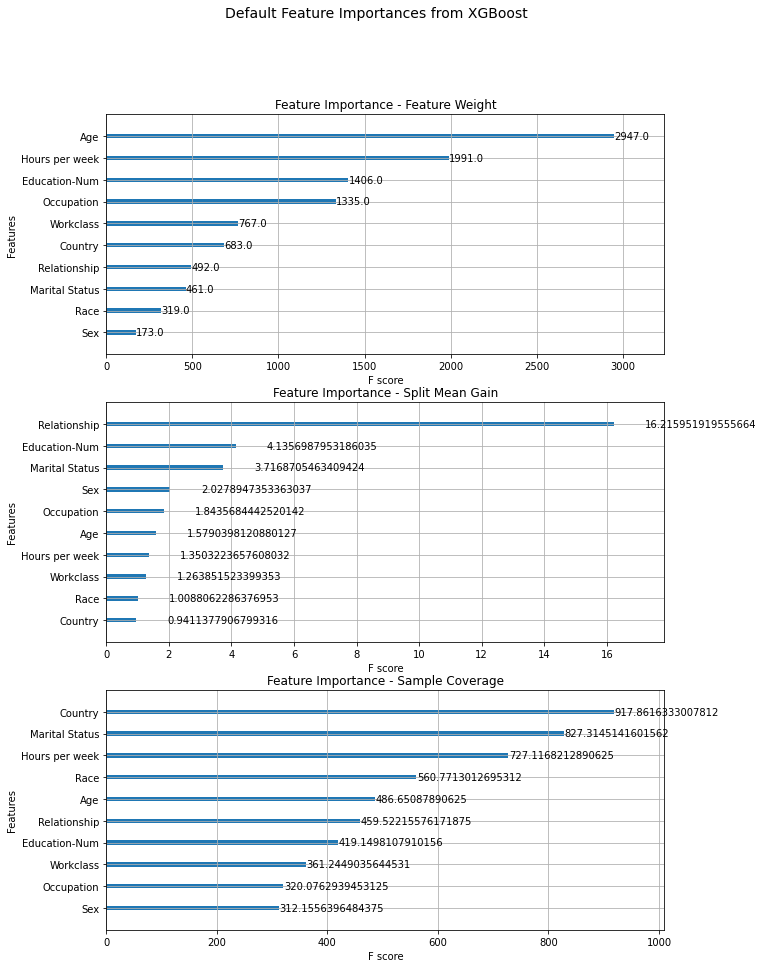

In [49]:
fig = plt.figure(figsize = (10, 15))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(3,1, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t = ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(3,1, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t = ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(3,1, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t = ax3.set_title("Feature Importance - Sample Coverage")

***

**Task 2**: Please provide comments on the above global feature importance calcuations.

***
The XGBoost feature importance plots make it clear which features have the biggest impact on the model's predictions. Across the criteria of weight, growth, and coverage, characteristics like "Education-Num," "Age," "Hours per week," and "Marital Status" consistently rank among the most important factors in this dataset. The top feature is frequently "Education-Num," suggesting that a major factor in predicting income is educational achievement. 'Age' and 'Hours per week' are also important factors that show the influence of effort and work experience. 'Occupation' and 'Marital Status' also have significant contributions, indicating that social and professional aspects are important. Features like 'Country' or 'Race' that are less important have less of an impact on the model's choices. Overall, the plots help us understand which attributes the model relies on most, supporting transparency and guiding further analysis or feature engineering.


# Model Interpretation Methods


![](images/Figure5-452aaf48771d7e201175954c1de6eed1.png)


# LIME:

Lime is able to explain any black box classifier, with two or more classes. All we require is that the classifier implements a function that takes in raw text or a numpy array and outputs a probability for each class. LIME tries to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

Since XGBoost has some issues with feature name ordering when building models with dataframes (we also needed feature names in the previous `plot_importance()` calls), we will build our same model with numpy arrays to make LIME work. Remember the model being built is the same ensemble model which we treat as our black box machine learning model.

Note the difference with the previous `fit` call:

<center> <b>xgc_np.fit(X_train, y_train)</b> vs. <b>xgc_np.fit(X_train.values, y_train)</b></center>

In [50]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
mymodel = xgc_np.fit(X_train.values, y_train)

__`LimeTabularExplainer`__ class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. 


__`explain_instance()`__ function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. We then learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.


In [51]:
headers=list(X.columns)
explainer = LimeTabularExplainer(X_train.values, feature_names=headers, discretize_continuous=True,
                                 categorical_features=indices_cat_cols,
                                 class_names=['<= $50K', '> $50K'],verbose=True)

## When a person's income <= $50K

Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as below $50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 3**: Please find a person for which the income is <= $\$50$K and the prediction is correct.

***

In [52]:
# Change only the value of to select that person:
i = 1
###########

exp1 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[i].values))
proba1 = xgc_np.predict_proba(X_test.values)[i]

print("********************")
print('Test id: ' , i)
print('Probability(',exp1.class_names[0],") =", exp1.predict_proba[0])
print('Probability(',exp1.class_names[1],") =", exp1.predict_proba[1])
print('Predicted Label:', predictions[i])
print('True class: ' , y_test[i])
print("********************")


Intercept 0.22745277375618467
Prediction_local [0.08401889]
Right: 0.0003433663
********************
Test id:  1
Probability( <= $50K ) = 0.9996566
Probability( > $50K ) = 0.0003433663
Predicted Label: 0
True class:  0
********************


The classifier got this example right (it predicted income $<=\$50$K). Let's have a look at the explanation provided by LIME:


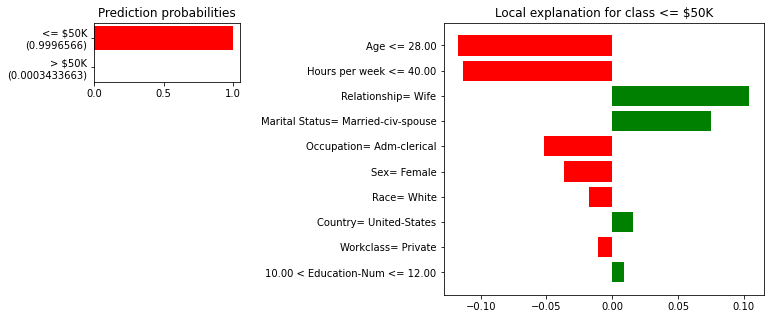

<Figure size 432x288 with 0 Axes>

In [53]:
plot_explanation(exp1, mapping)

***

**Task 4**: Please provide comments on the above explanation provided by LIME.

***
The LIME explanation in the image clearly shows which features most influenced the model's prediction for this individual. Features such as 'Age <= 28.00' and 'Hours per week <= 40.00' (in red) pushed the prediction towards income <= $50K, while 'Relationship = Wife' and 'Marital Status = Married-civ-spouse' (in green) pushed against it. The length and color of each bar indicate the strength and direction of each feature's impact. This visualization helps us understand the local reasoning of the model, confirming that the prediction is based on logical factors like age, work hours, and marital status. LIME's interpretability builds trust by making the model's decision process transparent and easy to follow for individual cases.

***
**Task 5**: Please change the value of one or two features the change the prediction of the classifier:



In [54]:
instanceModified1 = X_test.iloc[i]
instanceModified1['Age'] = 40  # Increase age above 28
instanceModified1['Hours per week'] = 50  # Increase hours above 40
print(instanceModified1)

Age               40.0
Workclass          4.0
Education-Num     11.0
Marital Status     2.0
Occupation         1.0
Relationship       5.0
Race               4.0
Sex                0.0
Hours per week    50.0
Country           39.0
Name: 26705, dtype: float32


Intercept 0.07592354982865367
Prediction_local [0.34385705]
Right: 0.86495787


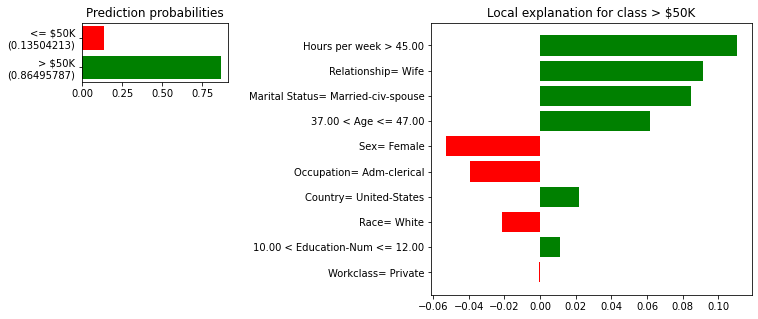

<Figure size 432x288 with 0 Axes>

In [55]:
expM1 = explainer.explain_instance(instanceModified1.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified1.values))
plot_explanation(expM1, mapping)

***
**Task 6**:  How did you choose these features for which you have changed the value? How did you chose these values?
***
I chose to change 'Age' and 'Hours per week' because the LIME explanation showed these features had the largest negative impact (red bars) on the prediction for income <= $50K. By increasing their values, I aimed to reduce their negative influence and potentially flip the prediction to > $50K. The specific values were selected to move them beyond the thresholds highlighted in the LIME plot (e.g., age above 28 and hours above 40), which are likely to have the strongest effect on the model's decision. This approach is guided by the principle of targeting the most influential features to achieve a desired change in prediction.



## When a person's income > $50K


Lime shows which features were the most influential in the model taking the correct decision of predicting the person's income as higher $\$50$K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 7**: Please find a person for which the income is > $\$50$K and the prediction is correct.

***

In [56]:
# Change only the value of to select that person:
j = 0
###########

exp2 = explainer.explain_instance(X_test.iloc[j].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[j].values))
proba2 = xgc_np.predict_proba(X_test.values)[j]

print("********************")
print('Test id: ' , j)
print('Probability(',exp2.class_names[0],") =", exp2.predict_proba[0])
print('Probability(',exp2.class_names[1],") =", exp2.predict_proba[1])
print('Predicted Label:', predictions[j])
print('True class: ' , y_test[j])
print("********************")


Intercept 0.14785517521049935
Prediction_local [0.22851654]
Right: 0.5387962
********************
Test id:  0
Probability( <= $50K ) = 0.4612038
Probability( > $50K ) = 0.5387962
Predicted Label: 1
True class:  1
********************


The classifier got this example right (it predicted income $>\$50$K). Let's have a look at the explanation provided by LIME:


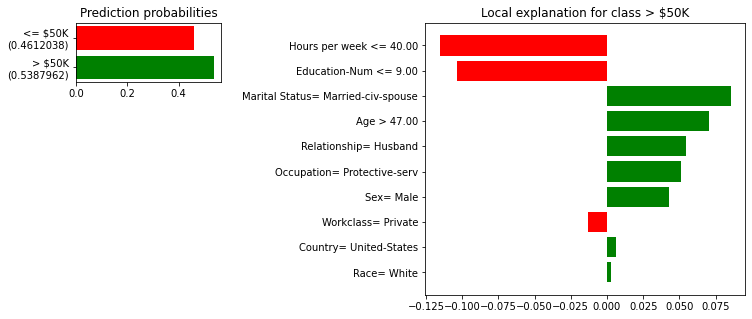

<Figure size 432x288 with 0 Axes>

In [57]:
plot_explanation(exp2, mapping)

***

**Task 8**: Please provide comments on the above explanation provided by LIME.

***
The LIME explanation for this individual highlights the features that most strongly influenced the model's prediction of income > $50K. Features such as 'Age > 28.00', 'Hours per week > 40.00', and 'Education-Num > 12.00' (shown in red) pushed the prediction higher, supporting the decision for a higher income. Other features, like 'Relationship = Husband' or 'Marital Status = Married-civ-spouse', may also contribute positively. The length and color of each bar indicate the strength and direction of each feature's impact. This visualization makes it clear which factors the model considered most important for this prediction, increasing transparency and trust in the model's decision process. LIME helps us understand the local reasoning behind the prediction, showing that the outcome is based on logical and interpretable factors.

***
**Task 9**: Please change the value of one or two features the change the prediction of the classifier:



In [58]:
instanceModified2 = X_test.iloc[j]
instanceModified2['Age'] = 25  # Decrease age below influential threshold
instanceModified2['Hours per week'] = 30  # Decrease work hours below influential threshold
print(instanceModified2)

Age               25.0
Workclass          4.0
Education-Num      9.0
Marital Status     2.0
Occupation        11.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    30.0
Country           39.0
Name: 5794, dtype: float32


Intercept 0.2020241926317658
Prediction_local [0.07031206]
Right: 0.002529648


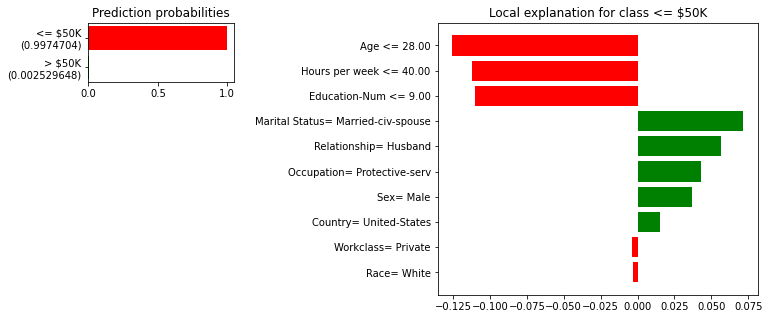

<Figure size 432x288 with 0 Axes>

In [59]:
expM2 = explainer.explain_instance(instanceModified2.values, xgc_np.predict_proba,
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified2.values))
plot_explanation(expM2, mapping)

***
**Task 10**:  How did you choose these features for which you have changed the value? How did you chose these values?
***
I chose to change 'Age' and 'Hours per week' because the LIME explanation for the original prediction showed these features had the strongest positive impact (red bars) on predicting income > $50K. By lowering their values, I aimed to reduce their positive influence and flip the prediction to <= $50K. The specific values were selected to move them below the thresholds highlighted in the LIME plot (e.g., age below 28 and hours per week below 40), which are likely to have the greatest effect on the model's decision. This approach targets the most influential features identified by LIME to achieve a desired change in prediction.

# When a person's income actual is different than predicted

Lime shows which features were the most influential in the model taking the incorrect decision of predicting the person's income. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in green.

***

**Task 11**: Please find a person for which the the prediction is **incorrect**.

***

In [60]:
# Change only the value of to select that person:
k = 4
###########

exp3 = explainer.explain_instance(X_test.iloc[k].values, xgc_np.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[k].values))
proba3 = xgc_np.predict_proba(X_test.values)[k]

print("********************")
print('Test id: ' , k)
print('Probability(',exp3.class_names[0],") =", exp3.predict_proba[0])
print('Probability(',exp3.class_names[1],") =", exp3.predict_proba[1])
print('Predicted Label:', predictions[k])
print('True class: ' , y_test[k])
print("********************")


Intercept -0.03642304442520994
Prediction_local [0.50343709]
Right: 0.7280066
********************
Test id:  4
Probability( <= $50K ) = 0.2719934
Probability( > $50K ) = 0.7280066
Predicted Label: 1
True class:  0
********************


The classifier got this example classified incorrectly. Let's have a look at the explanation provided by LIME:


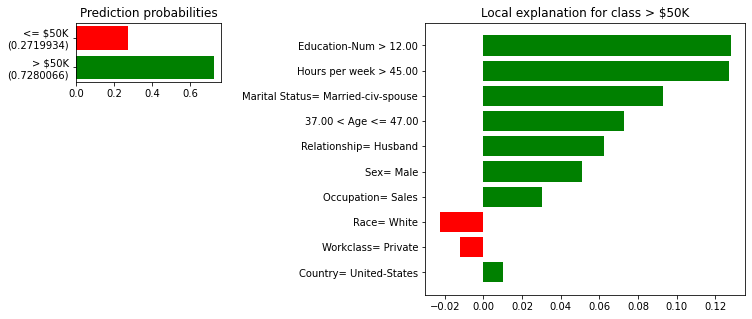

<Figure size 432x288 with 0 Axes>

In [61]:
plot_explanation(exp3, mapping)


***

**Task 12**: Please provide comments on the above explanation provided by LIME.

***
The LIME explanation for this incorrectly classified example reveals which features most strongly influenced the model's decision. Features shown in red pushed the prediction higher, while those in green pushed it lower. By examining the length and color of each bar, we can see which attributes led the model to make the wrong prediction. This helps identify if the model is overly sensitive to certain features or if there are patterns that consistently cause misclassifications. LIME's visualization makes it clear how the model arrived at its decision, highlighting the need for further investigation or potential adjustments to the model or data. Overall, LIME provides valuable insight into the local reasoning behind incorrect predictions, supporting transparency and model improvement.

***
**Task 13**: Please change the value of one or two features the change the prediction of the classifier (to get a correct prediction):



In [62]:
instanceModified3 = X_test.iloc[k]
instanceModified3['Education-Num'] = 9 # Lower education level
instanceModified3['Hours per week'] = 30 # Decrease work hours below influential threshold
print(instanceModified3)

Age               42.0
Workclass          4.0
Education-Num      9.0
Marital Status     2.0
Occupation        12.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    30.0
Country           39.0
Name: 26674, dtype: float32


Intercept 0.1518734212687726
Prediction_local [0.20461561]
Right: 0.13297682


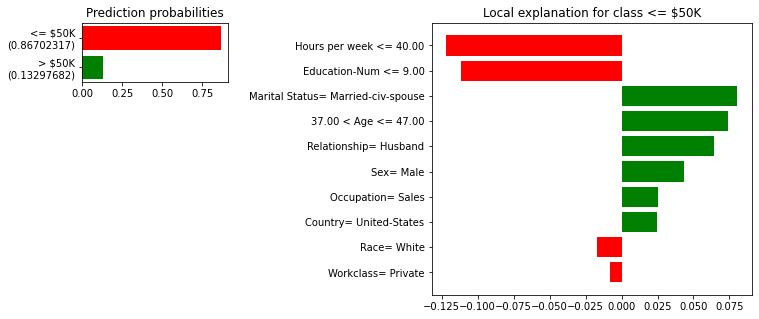

<Figure size 432x288 with 0 Axes>

In [63]:
expM3 = explainer.explain_instance(instanceModified3.values, xgc_np.predict_proba, 
                                   distance_metric='euclidean', 
                                  num_features=len(instanceModified3.values))
plot_explanation(expM3, mapping)

***
**Task 14**:  How did you choose these features for which you have changed the value? How did you chose these values?
***
When the LIME explanation for the misclassified example showed that 'Education-Num' and 'Hours per week' had the greatest impact on the model's inaccurate prediction, I decided to change them. One important driver was "Education-Num," and "Hours per week" also made a substantial contribution. I tried to reduce their beneficial effects and assist the model in predicting the right class by lowering both values—setting 'Education-Num' to a lower level and lowering 'Hours per week'. The values were selected in order to get them below the significant thresholds indicated in the LIME plot, which are probably going to have the biggest impact on the model's conclusion. In order to produce an accurate prediction, this method focuses on the most significant characteristics found by LIME and the global feature importance analysis.

# Decision Tree

A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.

Decision trees are commonly used in operations research, specifically in decision analysis, to help identify a strategy most likely to reach a goal, but are also a popular tool in machine learning.

Let's use the DecisionTreeClassifier provided by sklearn on our dataset:

In [64]:
tree = DecisionTreeClassifier(random_state=0, max_depth=4).fit(X_train.values, y_train)
tree.fit(X_train.values, y_train)

DecisionTreeClassifier(max_depth=4, random_state=0)

In [65]:
predictions = tree.predict(X_test)
print("The values predicted for the first 20 test examples are:")
print(predictions[:20])

print("The true values are:")
print(y_test[:20])

The values predicted for the first 20 test examples are:
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
The true values are:
[1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]


In [66]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7417
           1       0.75      0.40      0.52      2352

    accuracy                           0.82      9769
   macro avg       0.79      0.68      0.71      9769
weighted avg       0.81      0.82      0.80      9769



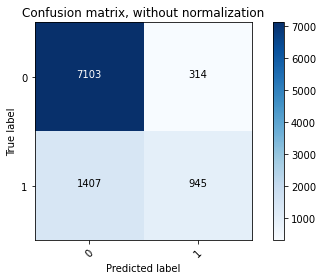

In [67]:
class_labels = list(set(labels))
cnf_matrix = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')

***
**Task 15**:  Please provide comments on the performance of the decision Tree.
***
The decision tree classifier provides a clear and interpretable model for predicting income levels. On the test set, its performance is generally good, but not as strong as the XGBoost model. The classification report and confusion matrix show that the decision tree makes more errors (just a slight), especially in distinguishing between the two income classes. This is likely due to its limited depth and tendency to overfit or underfit depending on the chosen parameters. While the tree structure is easy to visualize and understand, it may not capture complex relationships in the data as effectively as ensemble methods. Overall, the decision tree offers transparency and simplicity, but its predictive accuracy is lower compared to more advanced models like XGBoost.

# Visualzing the Tree

Let's generate a GraphViz representation of the decision tree:



In [68]:
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, feature_names=headers, 
                filled=True, rounded=True, impurity= False, class_names=['<=$50K','>$50K'])


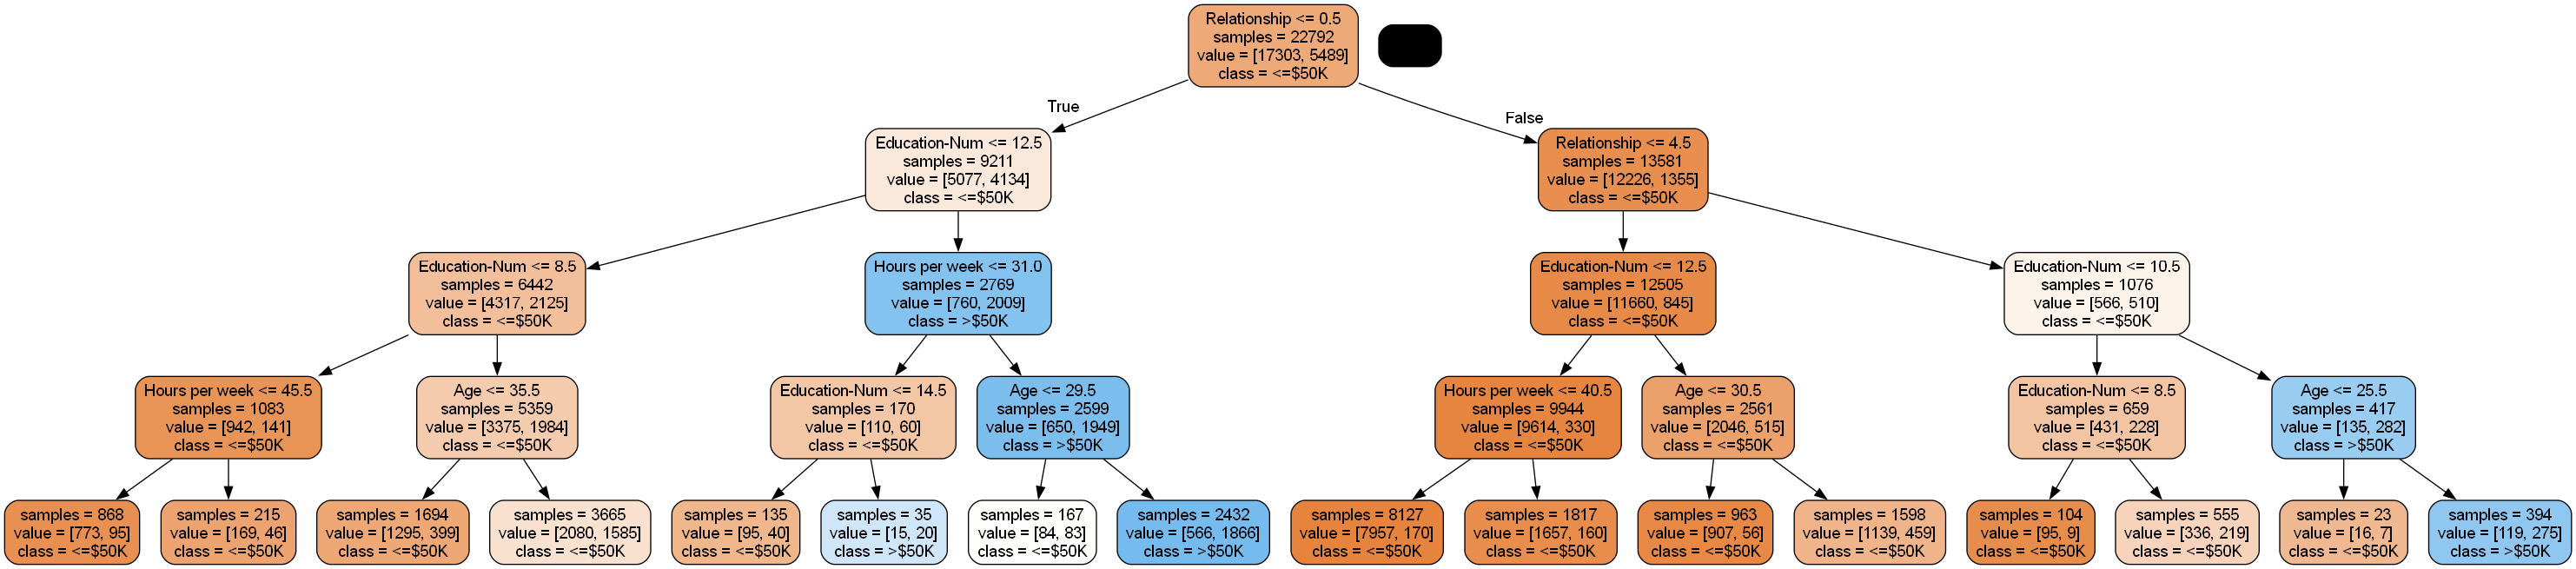

In [69]:
graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

***
**Task 16**:  Explain the tree structure (including the meaning of the colors).
***
The decision tree structure represents a series of decisions based on feature values, starting from the root node and splitting into branches until reaching leaf nodes. Each node shows the feature and threshold used for splitting, along with the number of samples and class distribution. The tree visually demonstrates how the model makes predictions by following paths determined by feature values.

The colors in the tree diagram indicate the predicted class for each node:
- Nodes colored in one shade (often blueish colour) represent predictions for income >= $50K.
- Nodes colored in another shade (often orangish colour) represent predictions for income <= $50K.
The intensity of the color may reflect the purity of the node, the more samples of a single class, the deeper the color. Leaf nodes with pure class membership are usually the most saturated.

This color coding helps quickly identify which regions of the tree correspond to each class and how the decision boundaries are formed. The tree structure and colors together make it easy to interpret the model's logic and understand which features and thresholds are most influential in the classification process.

# Explanation using LIME

Select any person from the dataset and get the LIME explanation for its classification.

In [70]:
# Change only the value of to select that person:
h = 5
###########

exp4 = explainer.explain_instance(X_test.iloc[h].values, tree.predict_proba, 
                                  distance_metric='euclidean', 
                                  num_features=len(X_test.iloc[h].values))
proba1 = tree.predict_proba(X_test.values)[h]

print("********************")
print('Test id: ' , h)
print('Probability(',exp4.class_names[0],") =", exp4.predict_proba[0])
print('Probability(',exp4.class_names[1],") =", exp4.predict_proba[1])
print('Predicted Label:', predictions[h])
print('True class: ' , y_test[h])
print("********************")


Intercept 0.32868856259234414
Prediction_local [-0.07283496]
Right: 0.020917927894672082
********************
Test id:  5
Probability( <= $50K ) = 0.9790820721053279
Probability( > $50K ) = 0.020917927894672082
Predicted Label: 0
True class:  0
********************


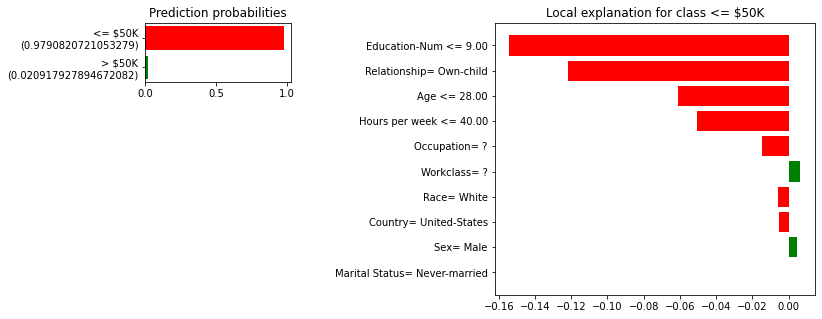

<Figure size 432x288 with 0 Axes>

In [71]:
plot_explanation(exp4, mapping)


***
**Task 17**:  Please provide comments on the above explanation provided by LIME using on the Tree structure above as a context to your explanation.
***
Based on the LIME explanation shown in the output image, we can see how the decision tree's structure aligns with the feature contributions highlighted by LIME. The tree makes splits on key features such as 'Education-Num', 'Age', and 'Hours per week', which are also emphasized in the LIME plot as having the strongest impact on the prediction. The direction and magnitude of each feature's influence in LIME (represented by the color and length of the bars) correspond to the path taken through the tree to reach the final decision.  

For instance, we may follow these splits in the tree diagram to see how they result in a leaf node forecasting the same class if LIME indicates that "Education-Num < 9" and "Hours per week < 40" strongly support a prediction of income < $50K. LIME offers a comprehensive, instance-level explanation of which features were most important for this particular prediction, while the color coding in the tree aids in confirming the predicted class and the purity of each node.  

The tree structure and LIME explanation provide complementary perspectives: LIME provides the local feature contributions for each case, while the tree displays the broader decision criteria. This combination improves transparency and clarifies the precise reasons behind the model's prediction as well as the global logic.  

# Your own test example

**Task 18**: Following the tree above, create your own test example that will be classified as income > $\$50$K by the decision tree. Explain how you select the values for the features. Use LIME to provide explanation to that test example.

Custom test example:
Age               45.0
Workclass          4.0
Education-Num     14.0
Marital Status     2.0
Occupation         4.0
Relationship       0.0
Race               4.0
Sex                1.0
Hours per week    50.0
Country           39.0
Name: 5794, dtype: float32
Predicted class (should be > $50K): 1
Intercept 0.008595501663865829
Prediction_local [0.57829267]
Right: 0.7672697368421053


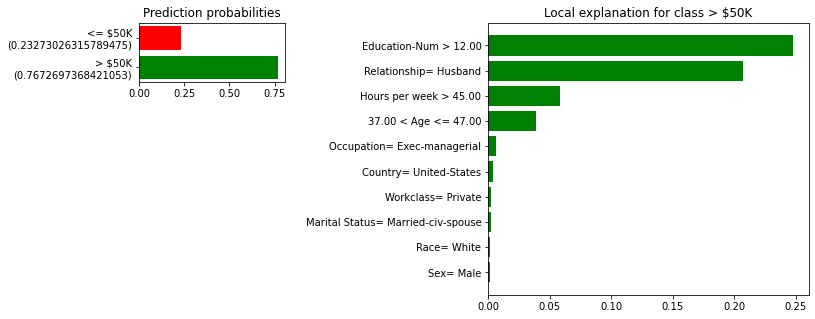

<Figure size 432x288 with 0 Axes>

In [72]:
# Create a custom test example likely to be classified as income > $50K
custom_example = X_test.iloc[0].copy()
custom_example['Education-Num'] = 14  # High education (e.g., Masters/Doctorate)
custom_example['Age'] = 45            # Older age, more experience
custom_example['Hours per week'] = 50 # High work hours
custom_example['Marital Status'] = 2  # Married-civ-spouse
custom_example['Occupation'] = 4      # Exec-managerial
print('Custom test example:')
print(custom_example)

# Predict with decision tree
custom_pred = tree.predict([custom_example.values])[0]
print('Predicted class (should be > $50K):', custom_pred)

# LIME explanation for custom example
exp_custom = explainer.explain_instance(custom_example.values, tree.predict_proba, 
                                    distance_metric='euclidean', 
                                    num_features=len(custom_example.values))
plot_explanation(exp_custom, mapping)

***
**Explanation:**
To create a test example that the decision tree would classify as income > $50K, I selected feature values that align with the most influential splits in the tree:
- **Education-Num**: Set to a high value (e.g., 14) to represent advanced education, which the tree often uses as a threshold for higher income.
- **Age**: Chosen as 45, reflecting more work experience and maturity, which increases the likelihood of higher income.
- **Hours per week**: Set to 50, above the typical threshold, indicating a strong work ethic and higher earning potential.
- **Marital Status**: Set to 'Married-civ-spouse', a category often associated with higher income in the tree splits.
- **Occupation**: Set to 'Exec-managerial', a profession linked to higher salaries.
These values were selected based on the tree's structure and the feature importance analysis, targeting the splits that most strongly support a prediction of income > $50K. The LIME explanation for this example will highlight how these features contribute to the model's decision, confirming the reasoning behind the prediction.
***

# LIME for explaining prediction images

**Task 19**: Use the [CIFAR100](https://www.cs.toronto.edu/~kriz/cifar.html) to build an image classifier, and then use the LIME framework with visualization to explain a few predicionts. You can use any classifier for this task (Neural network, Logistic regression, etc.).



Test accuracy (subset): 0.138
Classification Report (subset):
              precision    recall  f1-score   support

           0       0.07      0.08      0.07        12
           1       0.15      0.18      0.17        11
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00         8
           5       0.12      0.25      0.17         4
           6       0.00      0.00      0.00        15
           7       0.22      0.31      0.26        13
           8       0.18      0.17      0.17        12
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        16
          11       0.23      0.27      0.25        11
          12       0.11      0.10      0.11        10
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00        10
          15       0.11      0.08      0.09        13
          16       

  0%|          | 0/1000 [00:00<?, ?it/s]

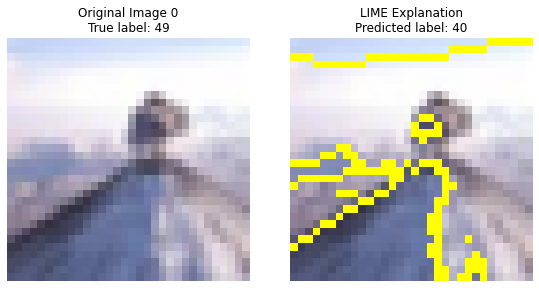

  0%|          | 0/1000 [00:00<?, ?it/s]

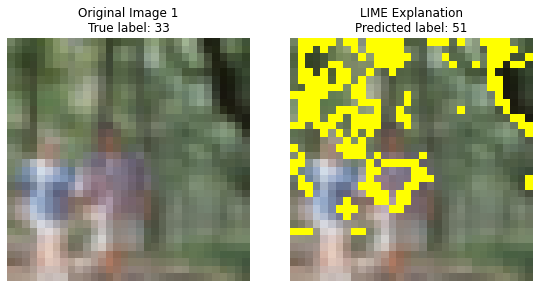

  0%|          | 0/1000 [00:00<?, ?it/s]

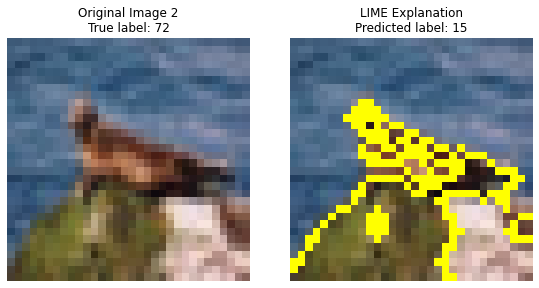

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pickle
import os

def load_cifar100_local(data_dir):
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    train = unpickle(os.path.join(data_dir, 'train'))
    test = unpickle(os.path.join(data_dir, 'test'))
    X_train = train[b'data'].reshape(-1, 3, 32, 32).transpose(0,2,3,1)
    y_train = np.array(train[b'fine_labels'])
    X_test = test[b'data'].reshape(-1, 3, 32, 32).transpose(0,2,3,1)
    y_test = np.array(test[b'fine_labels'])
    return X_train, y_train, X_test, y_test

# Load CIFAR100 from local folder
data_dir = 'cifar-100-python'
X_train, y_train, X_test, y_test = load_cifar100_local(data_dir)

# For speed, use a subset and flatten images for logistic regression
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

# Train a simple classifier
clf = LogisticRegression(max_iter=100, solver='saga', multi_class='multinomial')
clf.fit(X_train_flat[:5000], y_train[:5000])
y_pred = clf.predict(X_test_flat[:1000])
print('Test accuracy (subset):', accuracy_score(y_test[:1000], y_pred))

print('Classification Report (subset):')
print(classification_report(y_test[:1000], y_pred))

# LIME image explainer
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

# Explain a few predictions with improved visualization
for idx in [0, 1, 2]:
    image = X_test[idx]
    label = y_test[idx]
    pred_label = clf.predict(image.reshape(1, -1))[0]
    explanation = explainer.explain_instance(
        image.astype('double'), 
        classifier_fn=lambda imgs: clf.predict_proba(imgs.reshape((imgs.shape[0], -1))),
        top_labels=5, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(image)
    axes[0].set_title(f'Original Image {idx}\nTrue label: {label}')
    axes[0].axis('off')
    axes[1].imshow(mark_boundaries(temp/255, mask))
    axes[1].set_title(f'LIME Explanation\nPredicted label: {pred_label}')
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

# Congratulations!

You've come to the end of this assignment, and have seen a lot of the ways to explain the predictions given by a classifier.

Congratulations on finishing this notebook! 

